In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
# https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html#sphx-glr-auto-examples-classification-plot-lda-qda-py

from sklearn.metrics import confusion_matrix

from funcs import *
from clustering import *
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# sort 
def sort_labels(labels, data):
    num_cluster = np.max(labels) + 1
    sorted_index = np.argsort([np.mean(np.mean(data[labels == i] ,axis=0)) for i in range(num_cluster)])[::-1]
    sorted_labels = sort_categories_by_mean(labels, sorted_index)
    
    return sorted_labels

## load data

In [3]:
data = pd.read_excel('data/pretest_data.xlsx', index_col= '번호')

In [4]:
response_data = np.array(data.drop(columns=['성적/10']))

In [5]:
data_standardized = (response_data - np.mean(response_data, axis=0)) / np.std(response_data, axis=0)

In [6]:
items_for_each_component = {'Repetition':[1],'Probability':[2,3],'Conditional_Probablity':[4,5],
                            'Random_Variable':[6,7],'Probability_Distribution':[8,9],'Statistical_Estimation':[10]}

In [7]:
# plt.imshow(response_data, cmap='gray')
#data_standardized.shape

## Initialize using PCA & k-means

In [8]:
# Number of clusters
num_clusters = 3

itr = 0
all_labels = []

fit_pca = PCA(n_components=7, random_state=0).fit_transform(data_standardized)
print(fit_pca.shape)

# clustering by k-means 
km_pca = KMeans(n_clusters=num_clusters, random_state=0).fit(fit_pca)

labels = sort_labels(km_pca.labels_, data_standardized)
print(labels.shape)

all_labels.append(labels)


(95, 7)
(95,)


## update by iterating LDA and k-means

In [9]:
max_itr = 10

lda = LinearDiscriminantAnalysis()
km = KMeans(n_clusters=num_clusters, random_state=0)

for itr in range(1, max_itr+1):
    # 1. fit LDA with original (hig-dim) data and current label
    lda.fit(data_standardized, labels)

#     labels_lda = sort_labels(lda.predict(data_standardized), data_standardized)
    
#     # compare labels
#     cm = confusion_matrix(labels, labels_lda)
#     print(cm)

    # 2. project using LDA
    U = lda.coef_
#     print(U.shape)

    # normalize U
    norm = np.sqrt(np.sum(U ** 2,axis=1)).reshape((-1,1))
    U = U / norm

    projected = np.dot(data_standardized, U.T)
#     print(projected.shape)

    # 3. k-means clustering
    km_lda = km.fit(projected)

    labels_lda_km = sort_labels(km_lda.labels_, data_standardized)

    # compare labels
    cm = confusion_matrix(labels, labels_lda_km)
    print(cm)

    # update labels
    labels = labels_lda_km

[[31  0  0]
 [ 0 21  0]
 [ 1  1 41]]
[[32  0  0]
 [ 0 22  0]
 [ 1  0 40]]
[[33  0  0]
 [ 1 21  0]
 [ 0  0 40]]
[[34  0  0]
 [ 0 21  0]
 [ 0  0 40]]
[[34  0  0]
 [ 0 21  0]
 [ 0  0 40]]
[[34  0  0]
 [ 0 21  0]
 [ 0  0 40]]
[[34  0  0]
 [ 0 21  0]
 [ 0  0 40]]
[[34  0  0]
 [ 0 21  0]
 [ 0  0 40]]
[[34  0  0]
 [ 0 21  0]
 [ 0  0 40]]
[[34  0  0]
 [ 0 21  0]
 [ 0  0 40]]


In [10]:
labels

array([3, 1, 1, 3, 3, 2, 2, 3, 1, 2, 1, 1, 1, 1, 3, 2, 1, 1, 1, 3, 3, 2,
       3, 3, 2, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 2, 3, 1, 3, 1, 3, 1, 3, 2,
       3, 2, 1, 2, 1, 1, 3, 2, 3, 1, 1, 3, 1, 2, 2, 1, 1, 3, 3, 3, 3, 1,
       2, 3, 1, 3, 2, 3, 3, 1, 1, 3, 1, 3, 1, 2, 3, 1, 1, 3, 2, 2, 2, 3,
       2, 3, 1, 2, 3, 3, 3], dtype=int32)

## Visualize with `labels`

(-4, 4)

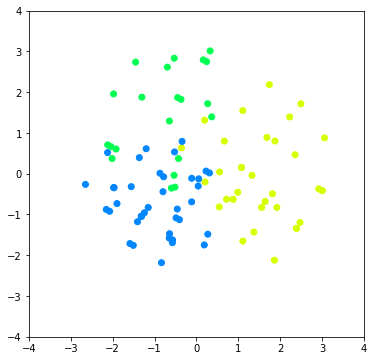

In [11]:
cmap = plt.get_cmap('hsv')
color = [cmap(i * 50) for i in labels]

plt.figure(figsize=(6,6))

plt.scatter(fit_pca[:,0], fit_pca[:,1], c = color)
plt.xlim(-4,4)
plt.ylim(-4,4)

In [12]:
pca_km_labels = np.load('pca_km.npz')['label']

(-4, 4)

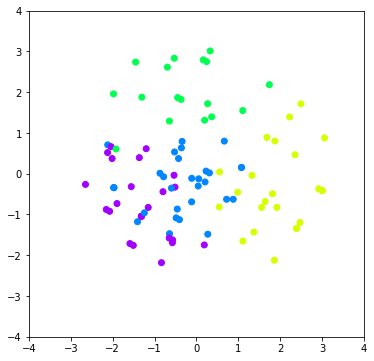

In [13]:
cmap = plt.get_cmap('hsv')
color = [cmap(i * 50) for i in pca_km_labels]

plt.figure(figsize=(6,6))

plt.scatter(fit_pca[:,0], fit_pca[:,1], c = color)
plt.xlim(-4,4)
plt.ylim(-4,4)

* Itemwise

In [14]:
itemwise_km = [np.mean(data_standardized[labels == i+1], axis=0) for i in range(num_clusters)]

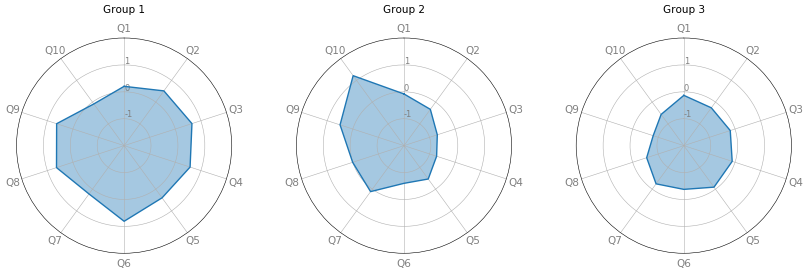

In [15]:
my_dpi=50
plt.figure(figsize=(1000/my_dpi, 750/my_dpi), dpi=my_dpi)

items = ['Q'+ str(i+1) for i in range(data_standardized.shape[1])]

for row in range(0, len(itemwise_km)):
    ax = plt.subplot(1,num_clusters,row + 1, polar=True)
    plt.subplots_adjust(wspace=0.3)
    values = itemwise_km[row]
    make_spider(items, values, row, ax, 'Group ' + str(row + 1))

* Componentwise

In [16]:
componentwise_km = list()

for i in range(1,num_clusters + 1):
    componentwise_km.append(calc_mean_components_by_group(items_for_each_component, itemwise_km, i))

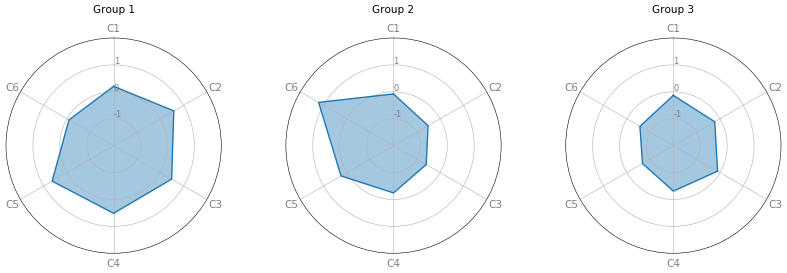

In [17]:
my_dpi=50
plt.figure(figsize=(1000/my_dpi, 750/my_dpi), dpi=my_dpi)

components = ['C'+str(i+1) for i in range(len(items_for_each_component.keys()))]

for row in range(0, len(componentwise_km)):
    ax = plt.subplot(1,num_clusters,row + 1, polar=True)
    plt.subplots_adjust(wspace=0.3)
    values = componentwise_km[row].values()
    make_spider(components, values, row, ax, 'Group '+ str(row + 1))